# Looking for the H alpha Raman wings in SMC-N60

Start off the same as the other notebooks - import the libraries and load the data

In [43]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
sns.set_context("talk")

In [44]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))
hacube = cube.select_lambda(6200.0, 6800.0)
cube_mask_orig = cube.mask.copy()
hacube_mask_orig = hacube.mask.copy()

The full data cube is in `cube`, while `hacube` is a 600 Å window around Hα.

Looking at the data cube in DS9 I found a region that looks promising fro the Raman wings, so we will look at that first:

[(0.0, 100.0)]

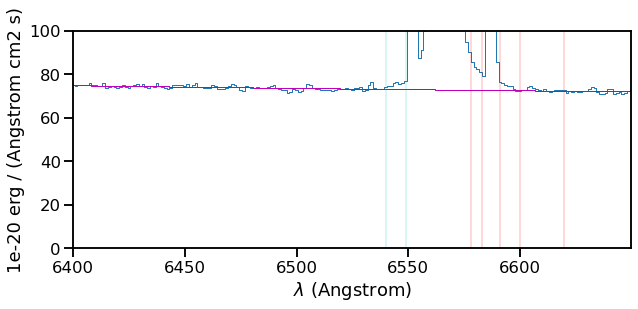

In [45]:
# hacube.mask = (my_mask_3d) | hacube_mask_orig
fig, ax = plt.subplots(figsize=(10, 4))
spec_ha = hacube[:, 240:250, 230:250].mean(axis=(1, 2))
spec2 = spec_ha.copy().subspec(6400, 6650)
spec2.mask_region(6500, 6600)
cont = spec2.poly_spec(2)
spec_ha.plot()
cont.plot(color="m")
ax.axvline(6578, c="r", lw=0.3)
ax.axvline(6583, c="r", lw=0.3)
ax.axvline(6591, c="r", lw=0.3)
ax.axvline(6600, c="r", lw=0.3)
ax.axvline(6620, c="r", lw=0.3)

ax.axvline(6540, c="c", lw=0.3)
ax.axvline(6549, c="c", lw=0.3)


ax.set(ylim=[0, 100])

So the red wing and blue wing look like they are definitely there. The red wing can be seen on both sides of the [N II] λ6583 line. In Orion, we only see it clearly for $\lambda > 6600$.  Perhaps this is because the C II λ6578 line is weaker in the LMC. 

First, make an image of the outer red wing:

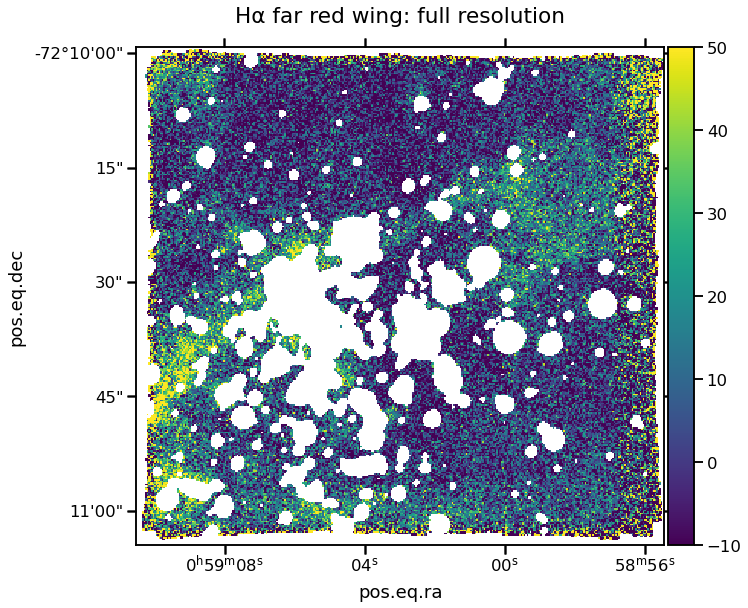

In [102]:
cont6600 = cube.select_lambda(6600.0, 6620.0).mean(axis=0)
wing = (cube.select_lambda(6591.0, 6600.0) - cont6600).sum(axis=0)
fig = plt.figure(figsize=(10, 10))
wing.mask = wing.mask | (cont6600.data > 100.0)
wing.plot(
    use_wcs=True,
    vmin=-10,
    vmax=50,
    cmap="viridis",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    "Hα far red wing: full resolution",
    fontsize="large",
    pad=25,
);

We see filamentary structure that is similar to the other emission lines (see 11-line-profiles notebook).  Note that I am masking out the stars by using a condition on `cont6600`.  It is a delicate balancing act between cutting out the PSF wings of the srars without losing too much of the nebular emission.


The map is very noisy but we can try and improve things by rebinning to 8x8.  I also take the opportunity to trim off a 10-pixel margin all around, since there are some very noisy pixels there.

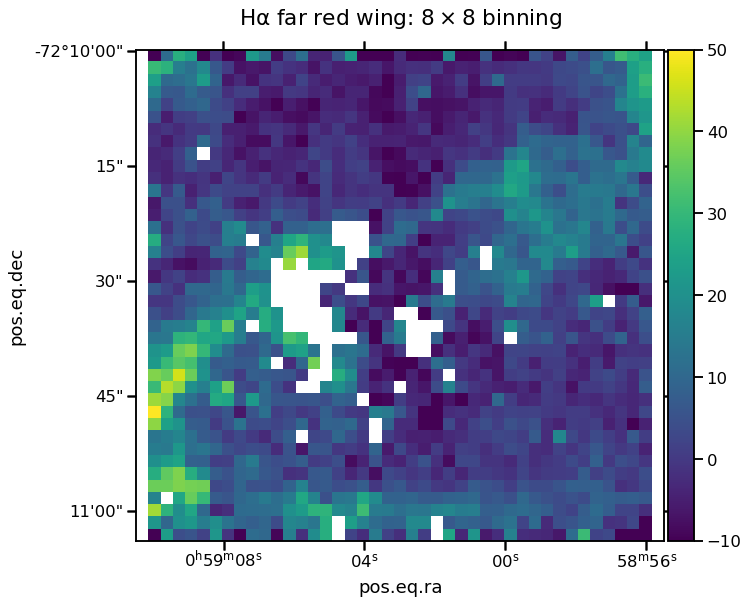

In [104]:
fig = plt.figure(figsize=(10, 10))
margin = 10
wing.mask[:margin, :] = True
wing.mask[-margin:, :] = True
wing.mask[:, :margin] = True
wing.mask[:, -margin:] = True
wing.rebin(8).plot(
    use_wcs=True,
    vmin=-10,
    vmax=50,
    cmap="viridis",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    r"Hα far red wing: $8\times8$ binning",
    fontsize="large",
    pad=25,
);

This looks a lot better.  We can see the central filament a lot more clearly. 

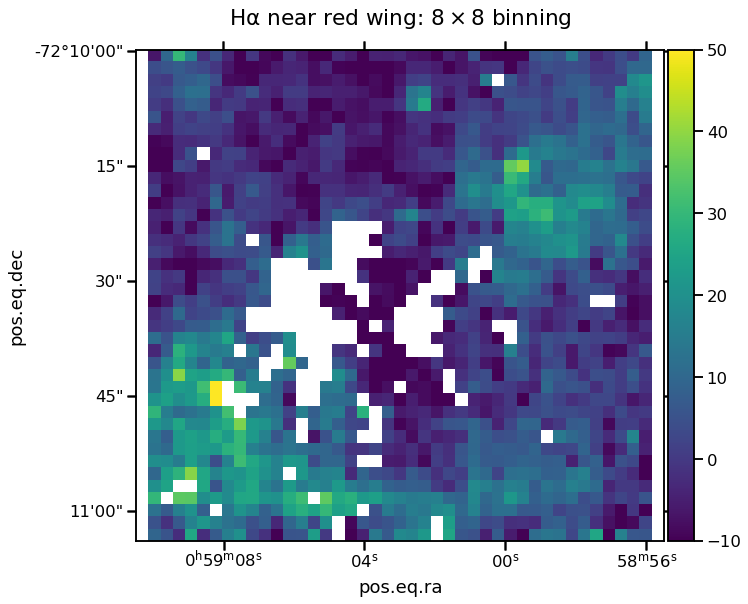

In [109]:
inwing = (cube.select_lambda(6578.0, 6583.0) - cont6600).sum(axis=0)
fig = plt.figure(figsize=(10, 10))
inwing.mask = inwing.mask | (cont6600.data > 70.0)
margin = 10
inwing.mask[:margin, :] = True
inwing.mask[-margin:, :] = True
inwing.mask[:, :margin] = True
inwing.mask[:, -margin:] = True
inwing.rebin(8).plot(
    use_wcs=True,
    vmin=-10,
    vmax=50,
    cmap="viridis",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    r"Hα near red wing: $8\times8$ binning",
    fontsize="large",
    pad=25,
);

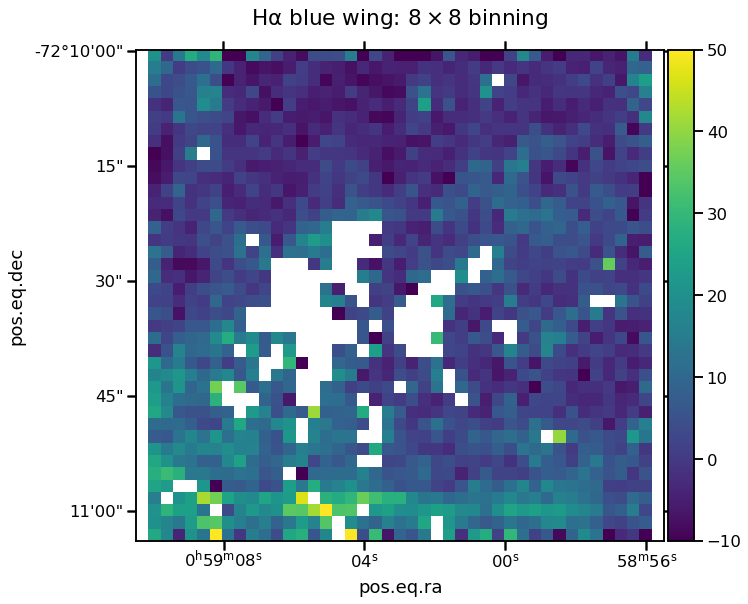

In [110]:
bluewing = (cube.select_lambda(6540.0, 6549.0) - cont6600).sum(axis=0)
fig = plt.figure(figsize=(10, 10))
bluewing.mask = bluewing.mask | (cont6600.data > 70.0)
bluewing.mask[:margin, :] = True
bluewing.mask[-margin:, :] = True
bluewing.mask[:, :margin] = True
bluewing.mask[:, -margin:] = True
bluewing.rebin(8).plot(
    use_wcs=True,
    vmin=-10,
    vmax=50,
    cmap="viridis",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    r"Hα blue wing: $8\times8$ binning",
    fontsize="large",
    pad=25,
);

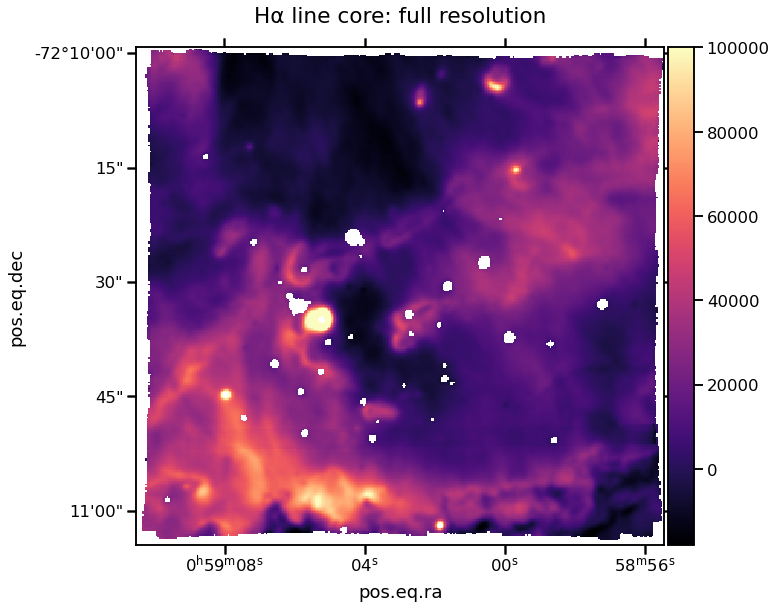

In [112]:
hacore = (cube.select_lambda(6555.0, 6578.0) - cont6600).sum(axis=0)
fig = plt.figure(figsize=(10, 10))
hacore.mask = hacore.mask | (cont6600.data > 3000.0)
hacore.rebin(1).plot(
    use_wcs=True,
    vmin=-1.8e4,
    vmax=1e5,
    cmap="magma",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    "Hα line core: full resolution",
    fontsize="large",
    pad=25,
);

Make some box regions for extracting the spectra.  I use the astropy affiliated `regions` package (see [docs](https://astropy-regions.readthedocs.io/en/latest/))

In [13]:
import regions

I make four boxes. The first two are in regions where the Raman wing is strong, while the second two are where it is weak. 

In [143]:
boxes = [
    # regions.BoundingBox(iymin=100, iymax=140, ixmin=15, ixmax=40),
    regions.BoundingBox(iymin=75, iymax=140, ixmin=15, ixmax=40),
    # regions.BoundingBox(iymin=180, iymax=240, ixmin=240, ixmax=300),
    regions.BoundingBox(iymin=200, iymax=250, ixmin=210, ixmax=300),
    regions.BoundingBox(iymin=10, iymax=50, ixmin=100, ixmax=150),
    regions.BoundingBox(iymin=10, iymax=100, ixmin=200, ixmax=300),
]

Plot an image of the entire bandbass in pixel coordinates and plot the boxes on top of it:

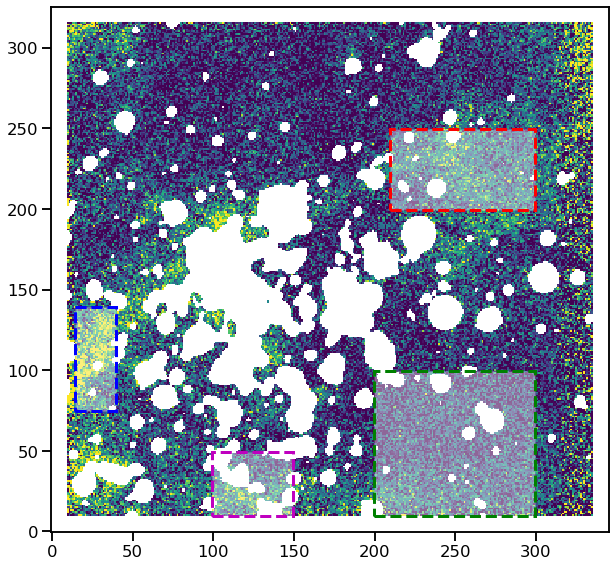

In [144]:
fig, ax = plt.subplots(figsize=(10, 10))
wing.rebin(1).plot(
    vmin=-10,
    vmax=50,
    scale="linear",
)
for box, c in zip(boxes, "brmg"):
    box.plot( 
        ax=ax, 
        lw=3, 
        edgecolor=c, 
        linestyle="dashed",
        facecolor=(1.0, 1.0, 1.0, 0.4), 
        fill=True,
    );

We can get the pixel slices from each box like this:

In [138]:
boxes[0].slices

(slice(100, 140, None), slice(15, 40, None))

So we can extract the spectrum for each box.  We apply the `wing` mask that we used above to the cube. (This is a much simpler way of combining a 2D and 3D mask). 

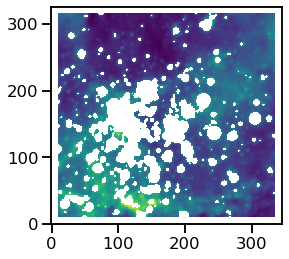

In [148]:
hacube.mask = hacube.mask | wing.mask[None, :, :]
hacube.sum(axis=0).plot()

I plot the spectrum for each box and also fit the continuum, so we can easily see if there are any Raman wings present.

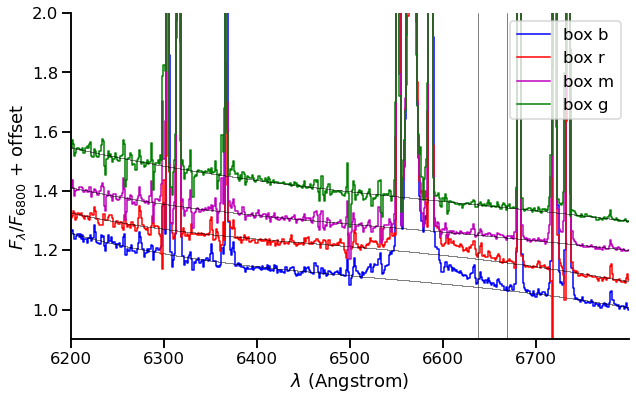

In [151]:
fig, ax = plt.subplots(figsize=(10, 6))
offset = 0.0
for box, c in zip(boxes, "brmg"):
    yslice, xslice = box.slices
    spec = hacube[:, yslice, xslice].mean(axis=(1, 2))
    spec /= spec[-1]
    spec += offset
    spec.plot(c=c, linewidth=1.5, label=f"box {c}")
    spec2 = spec.copy()
    spec2.mask_region(6290, 6400)
    spec2.mask_region(6490, 6695)
    spec2.mask_region(6712, 6740)
    cont = spec2.poly_spec(4)
    cont.plot(c="k", linewidth=0.5)
    offset += 0.1

ax.axvline(6633.0 * (1.0 + 200/3e5), color="k", lw=0.5)
ax.axvline(6664.0 * (1.0 + 200/3e5), color="k", lw=0.5)
ax.legend()
ax.set(ylim=[0.9,2.0], ylabel=r"$F_\lambda / F_{6800}$ + offset")
sns.despine()

The two boxes that were selected to cover the central filament (blue and red) show clear wings.  Better seen on the red side, but also there on the blue.

The other two boxes, which are off the filament (magenta and green) show no Raman wings at all.

I have put vertical lines at the wavelengths of the 6633 and 6664 features, assuming redshift of 200 km/s.  The 6633 feature is in the middle of two emission lines. What are they? **Could be night sky airglow lines**